In [1]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_excel('tagged data/all_codes.xlsx', sheet_name='Sheet1')
df = df[df['issuetype'] != 'Bug']

In [3]:
cols = df.columns[-9:]

In [4]:
cols_low = [col for col in cols if col.startswith('low')]
cols_medium = [col for col in cols if col.startswith('medium')]
cols_high = [col for col in cols if col.startswith('high')]

In [5]:
industry_projects = ['Company', 'Control', 'Data', 'Learn', 'Portfolio', 'Service', 'Store']
oss_projects = ['Cost_Management', 'Jira_Performance_Testing_Tools', 'Lyrasis Dura Cloud', 'Network_Observability', 'OpenShift_UX_Product_Design', 'Qt_Design_Studio', 'Red_Hat_Developer_Website_v2']

In [6]:
task_labels = ['Task', 'Sub-task', 'Technical task', 'Support-ticket']
rr_labels = ['Epic', 'Feature', 'Story', 'User Story', 'Suggestion']

In [7]:
order_projects = [ 'Control','Service', 'Store','Company', 'Portfolio',  'Data', 'Learn' ] +oss_projects

# RQ1

In [8]:
def check_labels_rr(row):
    if row['issuetype'] in ['Epic', 'Feature', 'Story', 'User Story', 'Suggestion']:
        if (row[cols_high + cols_medium + cols_low].sum() > 0):
            return 1
        else:
            return 0
    else:
        return -1
    
def check_labels_task(row):
    if row['issuetype'] in ['Task', 'Sub-task', 'Technical task', 'Support-ticket']:
        if (row[cols_high + cols_medium + cols_low].sum() > 0):
            return 1
        else:
            return 0
    else:
        return -1
    
def check_labels_ac(row, cols_low):
    if row['issuetype'] in ['Task', 'Sub-task', 'Technical task', 'Support-ticket']:
        if (row[cols_high + cols_medium].sum() > 0): 
            return 1
        else:
            return 0
    else:
        return -1
    
def check_labels_med_high(row, cols_high, cols_medium ):
    if row['issuetype'] in ['Epic', 'Feature', 'Story', 'User Story', 'Suggestion']:
        if (row[cols_high + cols_medium].sum() > 0):
            return 1
        else:
            return 0
    else:
        return -1

In [9]:
df['check_labels_rr'] = [check_labels_rr(row) for i, row in df.iterrows()]
df['check_labels_task'] = [check_labels_task(row) for i, row in df.iterrows()]
df['check_labels_low'] = [check_labels_ac(row, cols_low) for i, row in df.iterrows()]
df['check_labels_medhigh'] = [check_labels_med_high(row, cols_high, cols_medium) for i, row in df.iterrows()]

In [10]:
label_rr = 'check_labels_rr'
label_task = 'check_labels_task'
df_rq1_rr = df[df[label_rr] != -1]
df_rq1_task = df[df[label_task] != -1]
RQ1_rr = df_rq1_rr.groupby(['project_name'])[label_rr].agg(SumRR='sum', CountRR='count')

RQ1_task = df_rq1_task.groupby(['project_name'])[label_task].agg(SumTask='sum', CountTask='count')
RQ1_task[RQ1_task['SumTask'].isna()]
RQ1_rr['perc RR'] = (RQ1_rr['SumRR']/RQ1_rr['CountRR']).round(2)
RQ1_task['perc Task'] = (RQ1_task['SumTask']/RQ1_task['CountTask']).round(2)
RQ1_2 = RQ1_task.reset_index().merge(RQ1_rr.reset_index(), on = 'project_name', how = 'right')

RQ1_2[['SumTask', 'CountTask','perc Task']]= RQ1_2[['SumTask', 'CountTask', 'perc Task']].fillna(0)
RQ1_2['project_name'] = pd.Categorical(RQ1_2['project_name'], categories=order_projects, ordered=True)
#df_3 = df_3['project_name'].astype(priority_type)
RQ1_2.sort_values('project_name')

,project_name,SumTask,CountTask,perc Task,SumRR,CountRR,perc RR
1,Control,2.0,15.0,0.13,63,105,0.60
12,Service,13.0,37.0,0.35,59,63,0.94
13,Store,0.0,21.0,0.00,24,81,0.30
0,Company,0.0,0.0,0.00,16,29,0.55
9,Portfolio,2.0,9.0,0.22,44,88,0.50
3,Data,14.0,22.0,0.64,34,35,0.97
5,Learn,3.0,12.0,0.25,57,131,0.44
2,Cost_Management,14.0,57.0,0.25,53,122,0.43
4,Jira_Performance_Testing_Tools,3.0,20.0,0.15,47,85,0.55
6,Lyrasis Dura Cloud,1.0,7.0,0.14,80,105,0.76


In [14]:
#pd.merge(RQ1_2[['project_name','perc Task', 'perc RR']], RQ1[['project_name','perc Task', 'perc RR']], on = 'project_name').to_excel('rq1.xlsx')

In [11]:
#RQ1_2.to_excel('RQ1_table.xlsx')

In [11]:
print('For OSS projects:')
print('Mean % requirements in Tasks: {:0.2f}, with std of {:0.2f}\nMean % requirements in requirements items: {:0.2f}, with std of {:0.2f} \n'.format(
    np.mean(RQ1_2[RQ1_2['project_name'].isin(oss_projects)]['perc Task']),
    np.std(RQ1_2[RQ1_2['project_name'].isin(oss_projects)]['perc Task'], ddof=1),
    np.mean(RQ1_2[RQ1_2['project_name'].isin(oss_projects)]['perc RR']), 
    np.std(RQ1_2[RQ1_2['project_name'].isin(oss_projects)]['perc RR'], ddof=1)))

For OSS projects:
Mean % requirements in Tasks: 0.21, with std of 0.24
Mean % requirements in requirements items: 0.51, with std of 0.12 



In [12]:
print('For industry projects:')
print('Mean % requirements in Tasks: {:0.2f}, with std of {:0.2f}\nMean % requirements in requirements items: {:0.2f}, with std of {:0.2f} \n'.format(
    np.mean(RQ1_2[RQ1_2['project_name'].isin(industry_projects)]['perc Task']),
    np.std(RQ1_2[RQ1_2['project_name'].isin(industry_projects)]['perc Task'], ddof=1),
    np.mean(RQ1_2[RQ1_2['project_name'].isin(industry_projects)]['perc RR']), 
    np.std(RQ1_2[RQ1_2['project_name'].isin(industry_projects)]['perc RR'], ddof=1)))

For industry projects:
Mean % requirements in Tasks: 0.23, with std of 0.22
Mean % requirements in requirements items: 0.61, with std of 0.25 



In [13]:
print('Overall:')
print('Mean % requirements in Tasks: {:0.2f}, with std of {:0.2f}\nMean % requirements in requirements items: {:0.2f}, with std of {:0.2f} \n'.format(
    np.mean(RQ1_2['perc Task']), np.std(RQ1_2['perc Task'], ddof=1), np.mean(RQ1_2['perc RR']), np.std(RQ1_2['perc RR'], ddof=1)))

Overall:
Mean % requirements in Tasks: 0.22, with std of 0.22
Mean % requirements in requirements items: 0.56, with std of 0.20 



#### Boxplot

In [14]:
# data for detailed view

label_rr = 'check_labels_medhigh'
label_task = 'check_labels_low'
df_rq1_rr = df[df[label_rr] != -1]
df_rq1_task = df[df[label_task] != -1]
RQ1_rr = df_rq1_rr.groupby(['project_name'])[label_rr].agg(Sum='sum', Count='count')
RQ1_task = df_rq1_task.groupby(['project_name'])[label_task].agg(Sum='sum', Count='count')
RQ1_rr['perc RR'] = (RQ1_rr['Sum']/RQ1_rr['Count']).round(2)
RQ1_task['perc Task'] = (RQ1_task['Sum']/RQ1_task['Count']).round(2)

RQ1_detailed = RQ1_task.reset_index().merge(RQ1_rr.reset_index(), on = 'project_name', how = 'right')
RQ1_detailed[['Sum_x', 'Count_x','perc Task']]= RQ1_detailed[['Sum_x', 'Count_x','perc Task']].fillna(0)

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
def convert_data_boxplot(df, project_col, col_value, version):
    rename_category = col_value.split()[1] + ' (%)'
    return [{'combination': rename_category, 'project': 'OSS','version': version ,'perc': row[col_value] } if row['project_name'] in oss_projects 
                               else {'combination': rename_category, 'project': 'industry','version': version ,'perc': row[col_value] } 
                               for i, row in df[[project_col,col_value]].iterrows()]

In [18]:
all_boxplot_data = convert_data_boxplot(RQ1_detailed, 'project_name',"perc Task", 'detailed') + convert_data_boxplot(RQ1_detailed, 'project_name',"perc RR", 'detailed') + convert_data_boxplot(RQ1_2, 'project_name',"perc Task", 'general') +convert_data_boxplot(RQ1_2, 'project_name',"perc RR", 'general')


In [19]:
RQ1_boxplot = pd.DataFrame(all_boxplot_data)

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

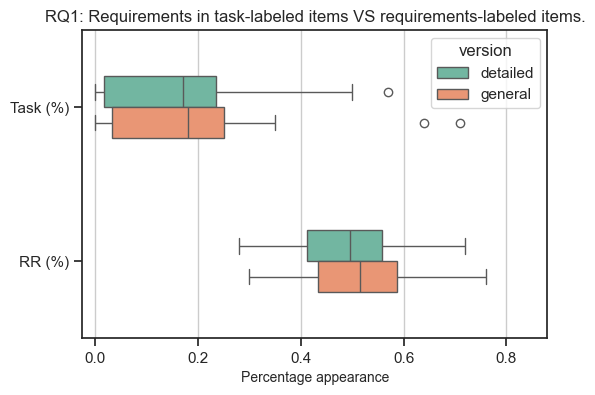

In [21]:
plt.figure(figsize=(6, 4))
#sns.set(style="ticks")
sns.set(style="ticks", palette='Set2')

g= sns.boxplot(data= RQ1_boxplot, y= 'combination', x = 'perc', hue = 'version', width=0.4)
plt.title('RQ1: Requirements in task-labeled items VS requirements-labeled items.', fontsize=12)
plt.xlabel('Percentage appearance', fontsize=10)
plt.grid(axis='x')
plt.ylabel('', fontsize=18)
plt.xlim(-0.025,0.88)
#plt.setp(g.get_xticklabels(), rotation=25, fontsize=18)
plt.savefig("RQ1_detailed.pdf", format="pdf")
plt.show()

In [22]:
print('For Tasks')
print('Median % requirements in Tasks in detailed: {:0.2f}, with std of {:0.2f}\nMedian % requirements in Tasks items in general: {:0.2f}, with std of {:0.2f} \n'.format(
    np.median(RQ1_detailed['perc Task'].fillna(0)),
    np.std(RQ1_detailed['perc Task'], ddof=1),
    np.median(RQ1_2['perc Task'].fillna(0)), 
    np.std(RQ1_2['perc Task'], ddof=1)))

For Tasks
Median % requirements in Tasks in detailed: 0.17, with std of 0.18
Median % requirements in Tasks items in general: 0.18, with std of 0.22 



In [23]:
print('For RR')
print('Median % requirements in RR  in detailed: {:0.2f}, with std of {:0.2f}\nMedian % requirements in RR items in general: {:0.2f}, with std of {:0.2f} \n'.format(
    np.median(RQ1_detailed['perc RR'].fillna(0)),
    np.std(RQ1_detailed['perc RR'], ddof=1),
    np.median(RQ1_2['perc RR'].fillna(0)), 
    np.std(RQ1_2['perc RR'], ddof=1)))

For RR
Median % requirements in RR  in detailed: 0.49, with std of 0.20
Median % requirements in RR items in general: 0.52, with std of 0.20 



In [24]:
RQ1_boxplot = RQ1_2[["perc Task","perc RR"]]
RQ1_boxplot.columns = ['Tasks', 'Requirements-related']

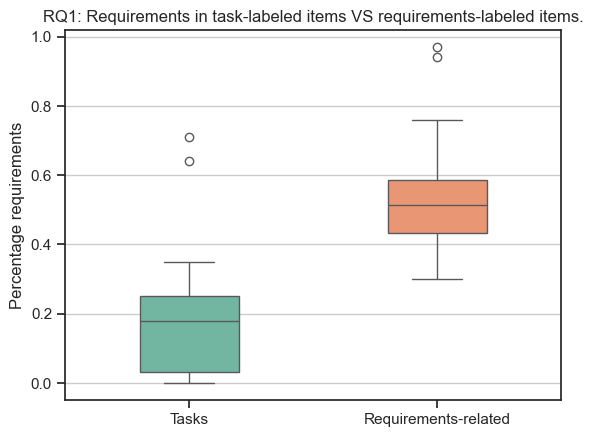

In [25]:
sns.boxplot(data= RQ1_boxplot, width=0.4)
plt.title('RQ1: Requirements in task-labeled items VS requirements-labeled items.')
plt.ylabel('Percentage requirements')
plt.grid(axis='y')
#plt.savefig("RQ1.pdf", format="pdf")
plt.show()


#### Hypothesis testing

In [26]:
RQ1_detailed['perc Task'].fillna(0)

0     0.00
1     0.07
2     0.19
3     0.50
4     0.15
5     0.25
6     0.14
7     0.00
8     0.57
9     0.22
10    0.19
11    0.00
12    0.24
13    0.00
Name: perc Task, dtype: float64

In [27]:
import scipy.stats as stats

In [28]:
stats.mannwhitneyu(x=RQ1_detailed['perc RR'], y=RQ1_detailed['perc Task'].fillna(0), alternative = 'greater',method="exact")

MannwhitneyuResult(statistic=178.0, pvalue=3.911099145989441e-05)

In [29]:
stats.mannwhitneyu(x=RQ1_2['perc RR'], y=RQ1_2['perc Task'].fillna(0), alternative = 'greater',method="exact")

MannwhitneyuResult(statistic=173.0, pvalue=0.0001343334180862785)

## RQ2

In [33]:
RQ2_1 = df.groupby('project_name')[cols].sum() #.reset_index()
RQ2_1['total req'] = RQ2_1.sum(axis = 1)

In [34]:
RQ2_1 = RQ2_1.reset_index()

In [35]:
RQ2_1

,project_name,high_user,high_system,high_nfr,medium_user,medium_system,medium_nfr,low_user,low_system,low_nfr,total req
0,Company,0,0,0,1,15,1,2,25,4,48
1,Control,6,0,2,40,8,12,114,24,21,227
2,Cost_Management,9,4,9,47,24,14,26,43,9,185
3,Data,5,0,1,36,0,11,79,1,10,143
4,Jira_Performance_Testing_Tools,2,0,1,34,4,16,5,3,3,68
5,Learn,2,0,1,59,8,5,70,16,4,165
6,Lyrasis Dura Cloud,1,1,2,44,22,31,0,1,3,105
7,Network_Observability,3,0,0,32,9,12,16,5,2,79
8,OpenShift_UX_Product_Design,12,0,3,70,2,33,24,0,11,155
9,Portfolio,2,1,1,30,10,5,104,36,26,215


In [36]:
categories = RQ2_1.columns[1:-1]

In [37]:
RQ2_1_perc = pd.DataFrame({row['project_name']:(row[categories]/ row['total req']).to_dict() for i,row in RQ2_1.iterrows()}).transpose()

In [38]:
RQ2_1_perc

,high_user,high_system,high_nfr,medium_user,medium_system,medium_nfr,low_user,low_system,low_nfr
Company,0.000000,0.000000,0.000000,0.020833,0.312500,0.020833,0.041667,0.520833,0.083333
Control,0.026432,0.000000,0.008811,0.176211,0.035242,0.052863,0.502203,0.105727,0.092511
Cost_Management,0.048649,0.021622,0.048649,0.254054,0.129730,0.075676,0.140541,0.232432,0.048649
Data,0.034965,0.000000,0.006993,0.251748,0.000000,0.076923,0.552448,0.006993,0.069930
Jira_Performance_Testing_Tools,0.029412,0.000000,0.014706,0.500000,0.058824,0.235294,0.073529,0.044118,0.044118
Learn,0.012121,0.000000,0.006061,0.357576,0.048485,0.030303,0.424242,0.096970,0.024242
Lyrasis Dura Cloud,0.009524,0.009524,0.019048,0.419048,0.209524,0.295238,0.000000,0.009524,0.028571
Network_Observability,0.037975,0.000000,0.000000,0.405063,0.113924,0.151899,0.202532,0.063291,0.025316
OpenShift_UX_Product_Design,0.077419,0.000000,0.019355,0.451613,0.012903,0.212903,0.154839,0.000000,0.070968
Portfolio,0.009302,0.004651,0.004651,0.139535,0.046512,0.023256,0.483721,0.167442,0.120930


In [39]:
RQ2_1_perc.describe() 

,high_user,high_system,high_nfr,medium_user,medium_system,medium_nfr,low_user,low_system,low_nfr
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,0.029300,0.004035,0.011877,0.321459,0.085507,0.106367,0.265778,0.118972,0.056706
std,0.020571,0.006850,0.013188,0.149965,0.087050,0.086397,0.188038,0.143195,0.028275
min,0.000000,0.000000,0.000000,0.020833,0.000000,0.020833,0.000000,0.000000,0.024242
25%,0.013328,0.000000,0.001163,0.252325,0.031367,0.049506,0.144115,0.018924,0.034714
50%,0.027922,0.000000,0.007902,0.314381,0.047498,0.076299,0.206105,0.072999,0.048518
75%,0.037222,0.005400,0.018523,0.443472,0.125255,0.145503,0.468851,0.152013,0.070708
max,0.077419,0.021622,0.048649,0.536842,0.312500,0.295238,0.552448,0.520833,0.120930


In [40]:
RQ2_1_perc.std(ddof=1)

high_user        0.020571
high_system      0.006850
high_nfr         0.013188
medium_user      0.149965
medium_system    0.087050
medium_nfr       0.086397
low_user         0.188038
low_system       0.143195
low_nfr          0.028275
dtype: float64

#### Boxplots

In [41]:
RQ2_1_perc = RQ2_1_perc[['low_user', 'low_system', 'low_nfr', 'medium_user', 'medium_system', 'medium_nfr','high_user', 'high_system', 'high_nfr']]

In [42]:
RQ2_1_perc

,low_user,low_system,low_nfr,medium_user,medium_system,medium_nfr,high_user,high_system,high_nfr
Company,0.041667,0.520833,0.083333,0.020833,0.312500,0.020833,0.000000,0.000000,0.000000
Control,0.502203,0.105727,0.092511,0.176211,0.035242,0.052863,0.026432,0.000000,0.008811
Cost_Management,0.140541,0.232432,0.048649,0.254054,0.129730,0.075676,0.048649,0.021622,0.048649
Data,0.552448,0.006993,0.069930,0.251748,0.000000,0.076923,0.034965,0.000000,0.006993
Jira_Performance_Testing_Tools,0.073529,0.044118,0.044118,0.500000,0.058824,0.235294,0.029412,0.000000,0.014706
Learn,0.424242,0.096970,0.024242,0.357576,0.048485,0.030303,0.012121,0.000000,0.006061
Lyrasis Dura Cloud,0.000000,0.009524,0.028571,0.419048,0.209524,0.295238,0.009524,0.009524,0.019048
Network_Observability,0.202532,0.063291,0.025316,0.405063,0.113924,0.151899,0.037975,0.000000,0.000000
OpenShift_UX_Product_Design,0.154839,0.000000,0.070968,0.451613,0.012903,0.212903,0.077419,0.000000,0.019355
Portfolio,0.483721,0.167442,0.120930,0.139535,0.046512,0.023256,0.009302,0.004651,0.004651


In [43]:
company_df = RQ2_1_perc.loc[industry_projects]
oss_df = RQ2_1_perc.loc[['Cost_Management', 'Jira_Performance_Testing_Tools', 'Lyrasis Dura Cloud', 'Network_Observability', 'OpenShift_UX_Product_Design', 'Qt_Design_Studio', 'Red_Hat_Developer_Website_v2']]

In [44]:
from itertools import chain


In [45]:
company_df.columns = ['low user', 'low system', 'low nfr','medium user', 'medium system',
       'medium nfr',  'high user', 'high system', 'high nfr']
oss_df.columns = ['low user', 'low system', 'low nfr','medium user', 'medium system',
       'medium nfr',  'high user', 'high system', 'high nfr']
company_df_raw = company_df.to_dict('index')
oss_df_raw = oss_df.to_dict('index')
company_df_rq2 = pd.DataFrame([{'combination': k_sub, 'project': k, 'perc': v_sub } for k, v in company_df_raw.items() for k_sub, v_sub in v.items() ])
oss_df_rq2 = pd.DataFrame([{'combination': k_sub, 'project': k, 'perc': v_sub } for k, v in oss_df_raw.items() for k_sub, v_sub in v.items() ])

company_df_rq2['project category'] = ['proprietary'] * len(company_df_rq2)
oss_df_rq2['project category'] = ['OSS'] * len(oss_df_rq2)

df_rq2 = pd.concat([oss_df_rq2, company_df_rq2])

df_rq2['granularity'] = df_rq2['combination'].str.split(' ').str[0]
df_rq2['type'] = df_rq2['combination'].str.split(' ').str[1]

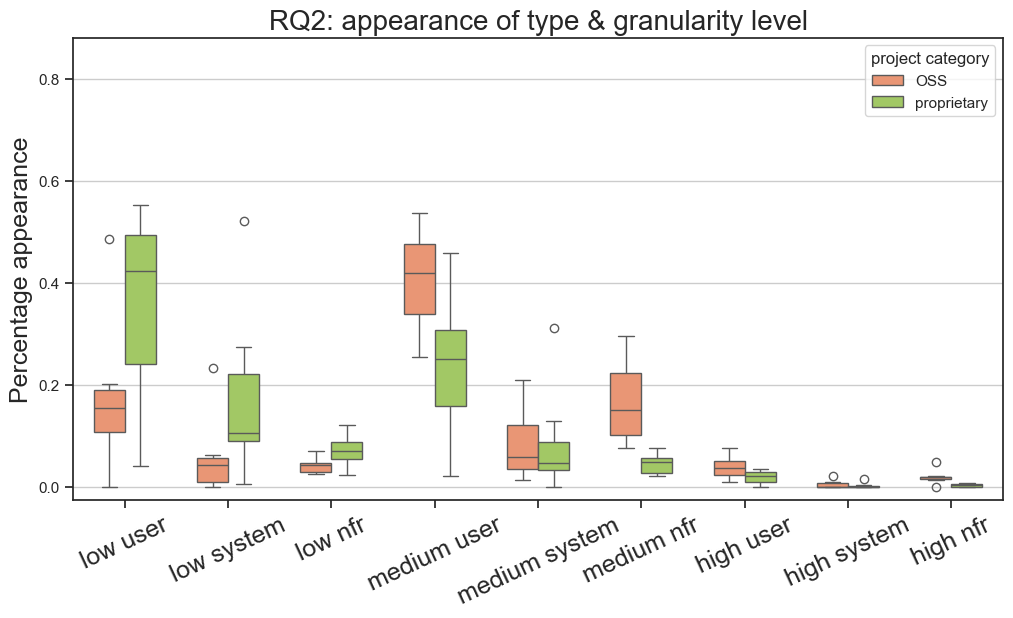

In [46]:
plt.figure(figsize=(12, 6))
custom_palette = [ "#fc8d62",  "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]

sns.set(style="ticks", palette=custom_palette)
g= sns.boxplot(data= df_rq2, x= 'combination', y = 'perc', hue = 'project category', width=0.6)
plt.title('RQ2: appearance of type & granularity level', fontsize=20)
plt.ylabel('Percentage appearance', fontsize=18)
plt.grid(axis='y')
plt.xlabel('', fontsize=18)
plt.ylim(-0.025,0.88)
plt.setp(g.get_xticklabels(), rotation=25, fontsize=18)
#plt.savefig("RQ2-2.pdf", format="pdf", pad_inches = 0.01, bbox_inches = 'tight')
plt.show()

In [50]:
#RQ2.to_excel('RQ2a.xlsx')

### RQ2b - multiple requirements

In [47]:
def check_mutliple_label_sum(row):
    present_codes = row[cols] > 0
    if present_codes.sum() > 0:
        return tuple(present_codes[present_codes].index)
    else:
        return ()

In [48]:
cols2 = ['high_nfr', 'medium_nfr', 'low_user',
       'medium_system', 'high_system', 'high_user', 'low_nfr', 'medium_user',
       'low_system']
df['sum multi label'] = df[cols2].sum(axis = 1)
df['multi_label'] = [check_mutliple_label_sum(row) for i, row in df.iterrows()]

In [49]:
df['sum_med'] = df[['medium_system', 'medium_nfr', 'medium_user']].sum(axis = 1)
df['sum_high'] = df[['high_system', 'high_nfr', 'high_user']].sum(axis = 1)
df['sum_low'] = df[['low_system', 'low_nfr', 'low_user']].sum(axis = 1)
df['multiplelow'] = [1 if med_label > 1 else 0 if med_label == 1 else -1 for med_label in df['sum_low']] 
df['multiplemed'] = [1 if med_label > 1 else 0 if med_label == 1 else -1 for med_label in df['sum_med']] 
df['multiplehigh'] = [1 if med_label > 1 else 0 if med_label == 1 else -1 for med_label in df['sum_high']] 

In [50]:
df['multiple_all'] = [1 if multi_label > 1 else 0 if multi_label == 1 else -1 for multi_label in df['sum multi label']] 


In [51]:
RQ2b = df.groupby(['project_name', 'multiple_all']).count()['id'].reset_index()

In [52]:
df_multi = RQ2b[(RQ2b['multiple_all'] == 1)]
df_single = RQ2b[(RQ2b['multiple_all'] == 0)]

In [53]:
df_2b = pd.merge(df_multi,df_single, on = 'project_name')


In [54]:
df_2b

,project_name,multiple_all_x,id_x,multiple_all_y,id_y
0,Company,1,13,0,3
1,Control,1,44,0,21
2,Cost_Management,1,37,0,30
3,Data,1,32,0,16
4,Jira_Performance_Testing_Tools,1,9,0,41
5,Learn,1,34,0,26
6,Lyrasis Dura Cloud,1,14,0,67
7,Network_Observability,1,19,0,24
8,OpenShift_UX_Product_Design,1,39,0,33
9,Portfolio,1,38,0,8


In [ ]:
df_two_codes_per_req = pd.read_excel('two_codes_per_req - OSS.xlsx', index_col=[0])

In [56]:
df_2b_adjusted = pd.merge(df_2b, df_two_codes_per_req, on='project_name', how='left')

In [57]:
df_2b_adjusted['count_multi'] = df_2b_adjusted['id_x'] - df_2b_adjusted['count']
df_2b_adjusted['count_single'] = df_2b_adjusted['id_y'] + df_2b_adjusted['count']
df_2b_adjusted['perc_multiple'] = (df_2b_adjusted['count_multi']/ ( df_2b_adjusted['count_multi']+ df_2b_adjusted['count_single'])).round(2)
df_2b_adjusted['perc_single'] = (df_2b_adjusted['count_single']/ ( df_2b_adjusted['count_multi']+ df_2b_adjusted['count_single'])).round(2)
df_2b_adjusted['perc_multiple_full'] = (df_2b_adjusted['id_x']/ ( df_2b_adjusted['id_x']+ df_2b_adjusted['id_y'])).round(2)
df_2b_adjusted['perc_single_full'] = (df_2b_adjusted['id_y']/ ( df_2b_adjusted['id_x']+ df_2b_adjusted['id_y'])).round(2)
#df_3_adjusted.to_excel('RQ3_1.xlsx')

In [58]:
df_2b_adjusted[['project_name', 'perc_multiple_full', 'perc_multiple']]


,project_name,perc_multiple_full,perc_multiple
0,Company,0.81,0.81
1,Control,0.68,0.62
2,Cost_Management,0.55,0.48
3,Data,0.67,0.46
4,Jira_Performance_Testing_Tools,0.18,0.12
5,Learn,0.57,0.47
6,Lyrasis Dura Cloud,0.17,0.04
7,Network_Observability,0.44,0.35
8,OpenShift_UX_Product_Design,0.54,0.35
9,Portfolio,0.83,0.74


In [59]:
print(df_2b_adjusted[df_2b_adjusted['project_name'].isin(industry_projects)]['perc_multiple_full'].mean(),
      df_2b_adjusted[df_2b_adjusted['project_name'].isin(industry_projects)]['perc_multiple'].mean(),
      df_2b_adjusted[df_2b_adjusted['project_name'].isin(industry_projects)]['perc_multiple_full'].std(ddof=1),
      df_2b_adjusted[df_2b_adjusted['project_name'].isin(industry_projects)]['perc_multiple'].std(ddof=1))

0.6657142857142857 0.572857142857143 0.165313554884563 0.1788588163621693


In [60]:
print(df_2b_adjusted[df_2b_adjusted['project_name'].isin(oss_projects)]['perc_multiple_full'].mean(),
      df_2b_adjusted[df_2b_adjusted['project_name'].isin(oss_projects)]['perc_multiple'].mean(),
      df_2b_adjusted[df_2b_adjusted['project_name'].isin(oss_projects)]['perc_multiple_full'].std(ddof=1),
      df_2b_adjusted[df_2b_adjusted['project_name'].isin(oss_projects)]['perc_multiple'].std(ddof=1))

0.3842857142857143 0.29857142857142854 0.15586929811620406 0.15805363767073627


In [61]:
print(df_2b_adjusted['perc_multiple_full'].mean(),
      df_2b_adjusted['perc_multiple'].mean(),
      df_2b_adjusted['perc_multiple_full'].std(ddof=1),
      df_2b_adjusted['perc_multiple'].std(ddof=1))

0.525 0.4357142857142858 0.2124852936087578 0.2157532167766


#### RQ2c

In [62]:
n = 6
RQ2_c = df.groupby(['project_name','multi_label']).count()['id'].reset_index()
RQ2_c = RQ2_c[RQ2_c['multi_label'].apply(len) > 1].sort_values('id',ascending=False)
#combined_rq3 = RQ3[RQ3['multi_label'].isin(RQ3_1.head(n)['multi_label'].to_list())]
RQ2_c = pd.merge(RQ2_c, df_2b_adjusted[['project_name', 'id_x']], on ='project_name', how = 'left')

RQ2_c_all = df.groupby(['multi_label']).count()['id'].reset_index()
RQ2_c_all = RQ2_c_all[RQ2_c_all['multi_label'].apply(len) > 1].sort_values('id',ascending=False)
RQ2_c_all['total_perc']=RQ2_c_all['id']/ sum(RQ2_c['id_x'])

RQ2_c_filtered = RQ2_c[RQ2_c['multi_label'].isin(RQ2_c_all.head(n)['multi_label'].to_list())].reset_index(drop=True)
RQ2_c_filtered.loc[:, 'perc comb'] = (RQ2_c_filtered['id']/RQ2_c_filtered['id_x']).round(2)
pivoted_df2c = RQ2_c_filtered.pivot(index='multi_label', columns='project_name', values='perc comb')
pivoted_df2c = pivoted_df2c.reindex(columns=[ 'Control','Service', 'Store',  'Company', 'Portfolio','Data', 'Learn' ] +oss_projects, index=RQ2_c_all['multi_label'].head(n).to_list())


In [63]:
pivoted_df2c


project_name,Control,Service,Store,Company,Portfolio,Data,Learn,Cost_Management,Jira_Performance_Testing_Tools,Lyrasis Dura Cloud,Network_Observability,OpenShift_UX_Product_Design,Qt_Design_Studio,Red_Hat_Developer_Website_v2
multi_label,,,,,,,,,,,,,,
"(medium_user, low_user)",0.41,0.44,0.22,NaN,0.45,0.47,0.38,0.08,0.22,NaN,0.37,0.13,0.20,0.50
"(medium_user, medium_nfr)",0.07,0.16,0.06,NaN,NaN,0.06,0.03,0.08,0.33,0.64,0.05,0.33,0.10,0.12
"(medium_system, low_system)",0.07,NaN,0.17,0.38,0.08,NaN,NaN,0.11,NaN,NaN,0.05,NaN,NaN,0.06
"(medium_user, low_user, low_system)",0.16,0.12,0.06,NaN,0.08,NaN,0.15,0.03,NaN,NaN,0.05,NaN,NaN,NaN
"(medium_user, low_user, low_nfr)",0.07,NaN,0.06,NaN,0.05,0.09,NaN,0.03,NaN,NaN,NaN,0.05,NaN,0.03
"(medium_user, medium_nfr, low_user)",NaN,NaN,NaN,NaN,NaN,0.16,NaN,0.03,NaN,NaN,0.05,NaN,0.05,0.06


In [68]:
#pivoted_df2c.to_excel('RQ1.2c.xlsx')

#### RQ2d

In [64]:
df_refined_type1 = df[((df['multiplemed'] == 1) & (df['multiplehigh'] == 0))]
df_rt1 = df_refined_type1[['project_name', 'id']].groupby(['project_name']).count()['id'].reset_index()
df_refined_type2 = df[((df['multiplelow'] == 1) & (df['multiplemed'] == 0))]
df_rt2 = df_refined_type2[['project_name', 'id']].groupby(['project_name']).count()['id'].reset_index()
#df_multimed = df_multimed.groupby(['project_name']).sum()['id'].reset_index()

count_multi column: adjusted count based on overall in requirements  

In [65]:
df_2d_total = df_2b_adjusted[['project_name','count_multi']].rename(columns={'project_name':'project_name','count_multi': 'total'})

In [66]:
df_2d = pd.merge(df_2d_total, df_rt1, on = 'project_name', how = 'left')
df_2d = pd.merge(df_2d, df_rt2, on = 'project_name', how = 'left')


In [67]:
df_2d = df_2d.rename(columns={'id_x': 'high_refined','id_y':'medium_refined'})

In [68]:
df_2d['perc_med'] = (df_2d['high_refined']/ ( df_2d['total'])).round(3)
df_2d['perc_low'] = (df_2d['medium_refined']/ ( df_2d['total'])).round(3)
df_2d
df_2d['project_name'] = pd.Categorical(df_2d['project_name'], categories=[ 'Control','Service', 'Store','Company', 'Portfolio',  'Data', 'Learn' ] +oss_projects, ordered=True)
#df_3 = df_3['project_name'].astype(priority_type)
df_2d[['high_refined', 'medium_refined', 'perc_med']]= df_2d[['high_refined', 'medium_refined', 'perc_med']].fillna(0)
df_2d.sort_values('project_name')

,project_name,total,high_refined,medium_refined,perc_med,perc_low
1,Control,40,1.0,33.0,0.025,0.825
12,Service,21,0.0,13.0,0.000,0.619
13,Store,15,0.0,8.0,0.000,0.533
0,Company,13,0.0,8.0,0.000,0.615
9,Portfolio,34,0.0,27.0,0.000,0.794
3,Data,22,0.0,13.0,0.000,0.591
5,Learn,28,0.0,19.0,0.000,0.679
2,Cost_Management,32,5.0,13.0,0.156,0.406
4,Jira_Performance_Testing_Tools,6,0.0,3.0,0.000,0.500
6,Lyrasis Dura Cloud,3,1.0,0.0,0.333,NaN


In [71]:
print(df_2d[df_2d['project_name'].isin(industry_projects)]['perc_med'].mean(),
      df_2d[df_2d['project_name'].isin(industry_projects)]['perc_low'].mean(),
      df_2d[df_2d['project_name'].isin(industry_projects)]['perc_med'].std(ddof=1),
      df_2d[df_2d['project_name'].isin(industry_projects)]['perc_low'].std(ddof=1))

0.0035714285714285718 0.6651428571428573 0.009449111825230682 0.10797596734370812


In [69]:
print(df_2d[df_2d['project_name'].isin(oss_projects)]['perc_med'].mean(),
      df_2d[df_2d['project_name'].isin(oss_projects)]['perc_low'].mean(),
      df_2d[df_2d['project_name'].isin(oss_projects) ]['perc_med'].std(ddof=1),
      df_2d[df_2d['project_name'].isin(oss_projects)]['perc_low'].std(ddof=1))

0.12485714285714287 0.38199999999999995 0.11629908078087373 0.19078050214841138


In [70]:
print(df_2d['perc_med'].mean(),
      df_2d['perc_low'].mean(),
      df_2d['perc_med'].std(ddof=1),
      df_2d['perc_low'].std(ddof=1))

0.06421428571428571 0.5344615384615385 0.10121354315841985 0.20634704399167572


In [434]:
#df_2d.to_excel('RQ1.2d.xlsx')

# RQ3

In [ ]:
df = pd.read_excel('tagged data/categories_per_item.xlsx')

In [93]:
med_high_categories = ['high_user', 'high_system', 'high_nfr', 'medium_user', 'medium_system','medium_nfr']
all_categories = ['low_user', 'low_system', 'low_nfr', 'medium_user', 'medium_system', 'medium_nfr', 'high_user', 'high_system', 'high_nfr']

In [94]:
df['sum'] = df[all_categories].sum(axis=1)
df['med_high_sum'] = df[med_high_categories].sum(axis=1)
RQ3 = df[df['sum'] >0].groupby('project_name').agg(['sum', 'count'])['motivation'][['sum', 'count']].reset_index()
RQ3_medhigh = df[df['med_high_sum'] >0].groupby('project_name').agg(['sum', 'count'])['motivation'][['sum', 'count']].reset_index()
RQ3['perc motivation'] = (RQ3['sum']/RQ3['count']).round(3)
RQ3_medhigh['perc motivation med high'] = (RQ3_medhigh['sum']/RQ3_medhigh['count']).round(3)

In [95]:
RQ3_table = pd.merge(RQ3[['project_name','perc motivation']], RQ3_medhigh[['project_name','perc motivation med high']], on = 'project_name')

In [96]:
RQ3_table['project_name'] = pd.Categorical(RQ3_table['project_name'], categories=[ 'Control','Service', 'Store','Company', 'Portfolio',  'Data', 'Learn' ] +oss_projects, ordered=True)
RQ3_table.sort_values('project_name')

,project_name,perc motivation,perc motivation med high
1,Control,0.123,0.133
12,Service,0.556,0.574
13,Store,0.625,0.609
0,Company,0.250,0.267
9,Portfolio,0.413,0.419
3,Data,0.562,0.600
5,Learn,0.217,0.211
2,Cost_Management,0.597,0.644
4,Jira_Performance_Testing_Tools,0.620,0.620
6,Lyrasis Dura Cloud,0.407,0.416


In [97]:
print(np.mean(RQ3[RQ3['project_name'].isin(oss_projects)]['perc motivation']),
np.std(RQ3[RQ3['project_name'].isin(oss_projects)]['perc motivation'], ddof= 1),
np.mean(RQ3_medhigh[RQ3_medhigh['project_name'].isin(oss_projects)]['perc motivation med high']),
np.std(RQ3_medhigh[RQ3_medhigh['project_name'].isin(oss_projects)]['perc motivation med high'], ddof= 1))



0.4161428571428572 0.1600723050909896 0.42842857142857144 0.16501096644653362


In [98]:
print(np.mean(RQ3[RQ3['project_name'].isin(industry_projects)]['perc motivation']),
np.std(RQ3[RQ3['project_name'].isin(industry_projects)]['perc motivation'], ddof= 1),
np.mean(RQ3_medhigh[RQ3_medhigh['project_name'].isin(industry_projects)]['perc motivation med high']),
np.std(RQ3_medhigh[RQ3_medhigh['project_name'].isin(industry_projects)]['perc motivation med high'], ddof= 1))

0.39228571428571435 0.19734716811219957 0.40185714285714286 0.19957991596636884


In [99]:
print(np.mean(RQ3['perc motivation']),
np.std(RQ3['perc motivation'], ddof= 1),
np.mean(RQ3_medhigh['perc motivation med high']),
np.std(RQ3_medhigh['perc motivation med high'], ddof= 1))

0.4042142857142857 0.17307320753032565 0.4151428571428571 0.17646871901617237


In [354]:
#RQ3_table.to_excel('RQ3.xlsx')